## AB Testing for 2 different designs of a website page (old_page vs. new_page)

### What is AB Testing?
A/B testing (also known as split testing) is the process of comparing two versions of a web page, email, or other marketing asset and measuring the difference in performance.

For example, the UX designer of an e-commerce company designs a new component or updates an existing component to their webpage. Now the old design is shown to a group of people and the newe design to another group. Based on the conversion rate of each design they determine the performance and then decide whether to accept or rejct the. new design.

## Steps of AB Testing

### 1. Designing the experiment:
Let us consider that the prouct manager of the company says that the conversion rate for the old design is 13% and we want that to be increased to 15% with the new design. 

1. First we need to formulate the null and alternate hypothesis and decide the type of the test(in our case two-tailed test)

**Null Hypothesis: The new design will have conversion rate of 15%**

**Alternate Hypothesis: The new design will not have conversion rate of 15%**

2. Next we need to set confidence level of 95%(alpha-0.05)

### 2. Choosing the variables
There are two test groups:

**Control group**: The group to which the old design is shown

**Treatment or experimental group**: The group to which the new desing is shown

Test groups are independent variables and conversion rate is dependeent variable

#### Let us now work on the first two steps in Python

### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import csv
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

### Reading the data set

<a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'>Link to Dataset</a>

In [2]:
df= pd.read_csv('ab_data.csv')

### View the data

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### Let's take a detailed look into the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
#checking for unique test group values
df.group.unique()

array(['control', 'treatment'], dtype=object)

In [6]:
#checking for unique landing page values
df.landing_page.unique()

array(['old_page', 'new_page'], dtype=object)

### Insights:
#### The dataset consists of 
* 294,478 users 
* 5 columns
* Two test groups: control and treatment
* Two product pages(landing page): old_page and new_page

In [7]:
#checking for null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### 3. Choosing a sample size
Having a large sample size helps in precise results. However, having too large sample can be expensive. So an optimal sample size can be estimated through **POWER ANALYSIS**.
Power Analysis depends on 3 factors:
1. **Power of test**:  This is usually set to 0.8
2. **Aplha value(confidence value)**:  0.05
3. **Effect size**:  How much difference of effect are we expecting. In this case the original conversion rate is 13% and we are expecting it to be 15% so 2% is the effect size

In [8]:
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  


In [9]:
# Rounding up to next whole number 
required_n = ceil(required_n)                                                   

print(f"The optimal sample size is: {required_n}")

The optimal sample size is: 4720


#### Before we go ahead and sample the data to get our subset, let's make sure there are no users that have been sampled multiple times.

In [10]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

In [11]:
print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


#### There are 3894 users that appear multiple times in the dataset. Since this is a small number we can drop them from our data

In [12]:
users_to_drop = session_counts[session_counts > 1].index


df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


### 4. Sampling
#### We can now sample `n=4720` entries from each group.

In [13]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [14]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [15]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [16]:
ab_test['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

#### Let's now calculate the conversion rates

In [17]:
#calculation of conversion rate
conversion_rates = ab_test.groupby('group')['converted']

conversion_rates = conversion_rates.agg([np.mean])
conversion_rates.columns = ['conversion_rate']


conversion_rates.style.format('{:.3f}')

,conversion_rate
group,
control,0.123
treatment,0.126


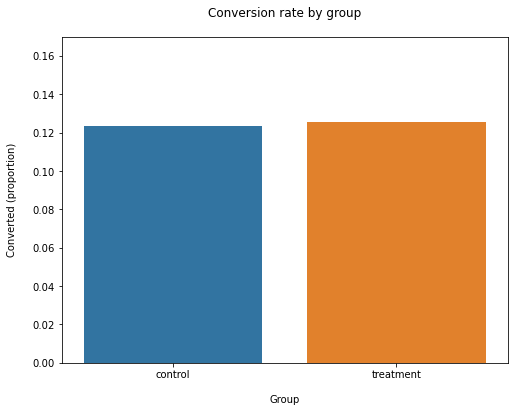

In [18]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### 5. Testing the hypothesis
Since the data set is large we can use normal approximation for calculating p-value.

In [19]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [20]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [22]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)


print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


### Conclusions

Since our $p$-value=0.732 is way above our $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that our new design did not perform significantly different

Additionally, if we look at the confidence interval for the `treatment` group ([0.116, 0.135], i.e. 11.6-13.5%) we notice that:
1. It includes our baseline value of 13% conversion rate
2. It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board! 